In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

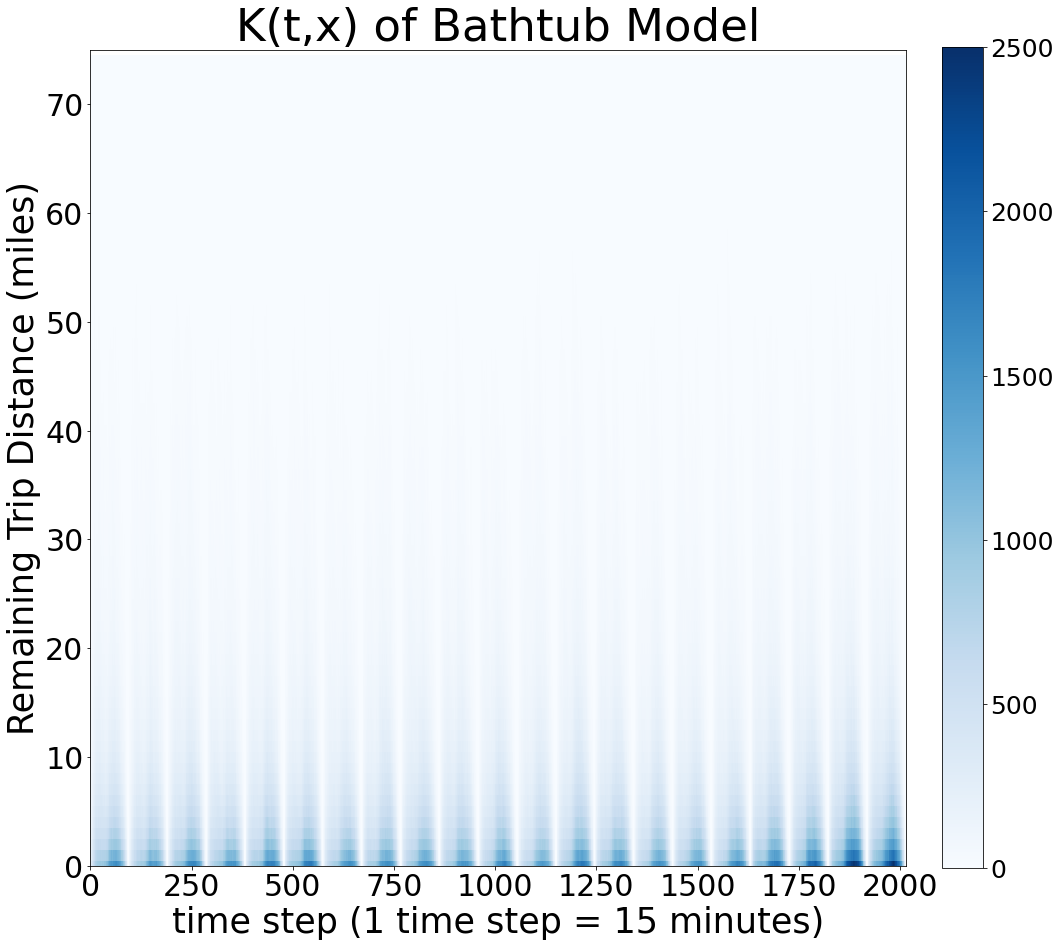

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [ ]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.066623604822916432 0.022498021902839505 0.11074918774299335 1.1453748192087903
0.0063078103720222009 0.0097880398154410429 0.0028275809286033588 0.7583621639455036
0.005975222595920095 0.0093943093599078865 0.0025561358319323036 0.7450586816083
0.0059487338218177019 0.0093663193277009373 0.0025311483159344656 0.7435972292188727
0.005895752658070747 0.0093604483902814586 0.0024310569258600358 0.7429394807619235
0.0057736542471849761 0.0094103371796444586 0.0021369713147254936 0.7444385217319305
0.005569776940484333 0.0095282850818660583 0.0016112687991026076 0.7490750882767412
0.0052916344240653 0.0095522992956770456 0.0010309695524535539 0.7507403002262829
0.0049377501953482249 0.0091140516448784854 0.00076144874581796421 0.7339783608824306
0.00473386999765096 0.0087360203790075152 0.00073171961629440486 0.7191384425175169
0.004683354193925517 0.0085814326392835774 0.000785275748567457 0.7125335200727664
0.0046490332391752875 0.0084647527400573373 0.0008333137382932382 0.707026560878

0.0032103737553624478 0.0055081473446746687 0.00091260016605022734 0.5742280649977589
0.0032097635747782784 0.0054894700328567475 0.00093005711669980919 0.5731827278954702
0.0032093905943157142 0.0054910837457155708 0.00092769744291585753 0.5732686335304573
0.0032088894778882445 0.005485371530559259 0.00093240742521723036 0.572956127735756
0.0032081882086860648 0.0054765485417278227 0.000939827875644307 0.5724463265663028
0.0032062838173471148 0.0054651858484438751 0.0009473817862503545 0.5717909711024047
0.0032046983978150484 0.005460304648808062 0.0009490921468220349 0.5714862319258598
0.0032021766886098685 0.0054503436808898383 0.00095400969632989849 0.5708560397453672
0.0031975885331835237 0.005451552485337568 0.00094362458102947931 0.5707572718738921
0.0031945657171806837 0.0054641083047724439 0.00092502312958892355 0.5713105205690087
0.00318919276226236 0.0054909169867842968 0.00088746853774042292 0.5727696420066296
0.0031870393664572109 0.0054803400864760817 0.000893738646438339

0.00316364349532057 0.0054262330693794145 0.00090105392126172518 0.568997771183208
0.0031625066840800247 0.0054272536325081274 0.00089775973565192168 0.5689061130889365
0.0031602111864541863 0.0054499687123574459 0.000870453660550927 0.5701732229317898
0.0031596784601627837 0.0054359060603491067 0.00088345085997646063 0.5695188869097204
0.003158619546055258 0.0054326533477304841 0.00088458574438003224 0.5693574162884999
0.0031569424786648086 0.0054275720156535551 0.00088631294167606242 0.5691476309523544
0.0031554307466202438 0.0054254082570302292 0.00088545323621025841 0.568957502210887
0.0031539890696239015 0.0054259723955229671 0.00088200574372483622 0.5690112955006577
0.003150018413224018 0.0054093384817157451 0.000890698344732291 0.5680619242735623
0.0031488091309202141 0.0054123716732065131 0.00088524658863391506 0.5682650872215029
0.0031480753117961563 0.0054130866592047161 0.00088306396438759659 0.568245871917653
0.003147608988323709 0.0054004539166659336 0.00089476405998148477

0.0030543171805273578 0.0052692625873138948 0.00083937177374082065 0.5604655293873376
0.0030540647098971892 0.00527320246294221 0.00083492695685216884 0.5606486662196835
0.0030539294220517182 0.0052739498700400244 0.000833908974063412 0.5606926431319612
0.0030537538307863449 0.0052739630988586431 0.00083354456271404677 0.5607129556047273
0.0030533181739530973 0.00527214468235151 0.00083449166555468453 0.5606801050329765
0.0030529602811617792 0.005273523507231751 0.00083239705509180711 0.5607755436364565
0.0030527022758882649 0.0052717860272193107 0.00083361852455721944 0.5606455861256117
0.0030525752267466727 0.0052701623198883989 0.00083498813360494693 0.5605606511491038
0.0030525301193261509 0.0052718760328237342 0.00083318420582856789 0.5606386550126036
0.0030524064511415218 0.0052730196683265472 0.00083179323395649615 0.5607000878268086
0.0030516851429003952 0.0052787693551187053 0.00082460093068208531 0.5609992207282616
0.0030507663582966626 0.00527693290351707 0.00082459981307625

0.0030252250953025257 0.0052036420374588638 0.00084680815314618736 0.5569764225765628
0.0030248815061853242 0.0051936796033738228 0.000856083408996826 0.5564216591306334
0.0030247338081271849 0.0051888909698269044 0.000860576646427465 0.5561681306235194
0.0030246228283476685 0.00518499360904014 0.00086425204765519688 0.5559675796575744
0.0030244009759847353 0.0051894958270036007 0.00085930612496587012 0.55619889210999
0.0030242924344733276 0.0051886674262566126 0.0008599174426900428 0.5561889369620793
0.0030241949209203378 0.0051904538606172895 0.00085793598122338639 0.5562916182847792
0.0030241322880124161 0.005188501930822465 0.00085976264520236693 0.5561719640514232
0.0030240907587696089 0.0051918844942573312 0.00085629702328188651 0.5563412342418327
0.003024057709811425 0.0051904924766053226 0.00085762294301752772 0.5562767151298152
0.0030240393399448297 0.0051900834330490782 0.00085799524684058114 0.5562519918449988
0.0030239999431936736 0.005190124349248231 0.00085787553713911652

0.0030096858629333856 0.0051305727171056153 0.00088879900876115566 0.5531932823078335
0.0030096605091867279 0.0051306811715744376 0.00088863984679901826 0.5531923383976881
0.0030096268833590292 0.0051316791685391237 0.00088757459817893458 0.5532413028611701
0.0030095911809812303 0.0051322132265674107 0.00088696913539504949 0.5532741873261714
0.003009566340788711 0.00513409052461967 0.00088504215695775262 0.553358177391567
0.00300949606176738 0.0051345269393437455 0.00088446518419101408 0.5533972536726717
0.003009346311479387 0.0051342775784245865 0.00088441504453418726 0.5534088978616934
0.00300909949547454 0.0051351250876568652 0.0008830739032922155 0.5534803126813171
0.0030086679146614182 0.0051355368813288662 0.00088179894799396983 0.5535190926118296
0.0030083471479438397 0.0051456391671055113 0.0008710551287821679 0.5540608028941177
0.0030079909252055952 0.0051443794637724355 0.00087160238663875451 0.553970008336243
0.0030075060906327908 0.0051324982376746049 0.000882513943590977 0

0.002998171274752 0.0051122529894860862 0.00088408956001791335 0.5521613322047795
0.0029981123288561891 0.0051157126962082348 0.00088051196150414339 0.5523661452788886
0.0029980378979248112 0.0051121756697968031 0.0008839001260528193 0.5521860071512602
0.0029979101832786361 0.0051113762019608672 0.000884444164596405 0.5521449885427647
0.0029977381943717307 0.0051173022779414015 0.00087817411080205992 0.5524453063821696
0.0029975868958197218 0.005112363437690037 0.00088281035394940661 0.5521967501956054
0.0029972258624264927 0.0051079945461409253 0.00088645717871205991 0.5519519334061164
0.00299676738098729 0.00511273719744392 0.00088079756453066039 0.5521594626237368
0.0029964156542519431 0.0051128225017738468 0.00088000880673003981 0.5521634821417397
0.0029961473401432883 0.0051244820434846348 0.00086781263680194216 0.5528224259235964
0.0029959233614249327 0.0051138113966836558 0.00087803532616620981 0.5522866656462455
0.0029956546955733692 0.0051111267629209952 0.00088018262822574342

0.0029861920419156423 0.0050864796637910114 0.00088590442004027315 0.5510781786143036
0.0029861459729154049 0.0050874387417371445 0.00088485320409366559 0.5511192613659397
0.002986081477264097 0.0050883583361049306 0.00088380461842326374 0.5511510802184933
0.0029860099744146262 0.0050907440744189115 0.000881275874410341 0.5512751551759701
0.0029859127087792994 0.0050869200682722836 0.00088490534928631489 0.5510631237968708
0.0029857414489426509 0.0050911557948728524 0.00088032710301244935 0.551297944384761
0.0029855889363740503 0.0050921519412758806 0.00087902593147221964 0.5513672336512873
0.0029854779105195892 0.0050910606910843769 0.00087989512995480192 0.5513341423474702
0.0029851798050448027 0.00508589443727359 0.00088446517281601494 0.5510758398743314
0.0029849340324337994 0.0050881019561821884 0.00088176610868541069 0.551237021174515
0.0029845877882799551 0.00508728104079767 0.00088189453576224049 0.5512265311309745
0.0029842692718555467 0.0050838407394000864 0.00088469780431100

0.0029378665603648894 0.0050244865727999922 0.00085124654792978656 0.5481386358152744
0.0029371060922750176 0.00503365399175526 0.00084055819279477454 0.5486307152984211
0.0029364993225080276 0.0050287763014401164 0.00084422234357593891 0.5483685908121788
0.0029356435587258606 0.0050297611179170691 0.000841525999534652 0.5483964326275628
0.002934859851458541 0.0050282353318156945 0.00084148437110138712 0.5482986891796376
0.0029340606063063971 0.0050314548717449179 0.00083666634086787626 0.5484538359244553
0.0029336738752600623 0.0050287933793556226 0.00083855437116450184 0.5482883249005869
0.0029332264439768476 0.0050326406696253149 0.00083381221832838051 0.5484824884024602
0.0029328278182576334 0.0050309437062675353 0.000834711930247731 0.5483902690144564
0.00293182619286328 0.0050325474162389219 0.00083110496948763767 0.54848644691894
0.0029311369513415381 0.0050247354284883756 0.00083753847419470052 0.5481066599141765
0.0029307577121396441 0.0050254451155070925 0.0008360703087721961

0.0029134007605780355 0.0049854375328080352 0.00084136398834803528 0.5463505981000439
0.0029133786640426589 0.0049841842231078117 0.000842573104977506 0.5462886824703855
0.0029133535634577796 0.0049827289650261463 0.00084397816188941323 0.5462132994291057
0.0029133363263717329 0.00498138288725188 0.00084528976549158585 0.5461402008922103
0.002913323328339293 0.0049809482097035252 0.00084569844697506068 0.5461180399476578
0.0029133058222594065 0.0049807504640851505 0.00084586118043366275 0.5461090013775258
0.0029132728431552945 0.0049810716027592957 0.00084547408355129319 0.5461321019397394
0.0029132494251160107 0.0049817546482475716 0.00084474420198444959 0.5461823015227057
0.0029132259532102548 0.0049815431026387393 0.00084490880378177032 0.5461743831364261
0.0029132005346617384 0.0049812369017152155 0.00084516416760826117 0.5461605450040955
0.0029131724233426078 0.004980246586605442 0.00084609826007977335 0.5461087275283467
0.0029131263382508959 0.0049782533438717125 0.00084799933263

0.0029063098980669959 0.0049679641285063757 0.0008446556676276161 0.5454757858502813
0.0029062384338986295 0.0049678806652962678 0.00084459620250099121 0.5454601715331981
0.0029061789167418536 0.004966478390186096 0.000845879443297611 0.5453585138423047
0.0029060596563721484 0.0049662650753109832 0.00084585423743331351 0.5453342735064671
0.002906019247341826 0.004966637486668069 0.00084540100801558252 0.5453483440156977
0.0029059906937109843 0.0049670277634147227 0.00084495362400724622 0.5453637618837256
0.0029059753068050977 0.0049670757735818145 0.00084487484002838042 0.5453667313721055
0.0029059629527482546 0.0049675480924095483 0.00084437781308696082 0.5453997297054901
0.0029059526119847956 0.0049672123397928253 0.00084469288417676563 0.545378493964628
0.002905939848729955 0.0049673088149375351 0.00084457088252237484 0.5453832966458956
0.0029059191812919704 0.0049678455079642169 0.00084399285461972428 0.54540985153498
0.0029058929366425476 0.0049670379458416972 0.000844747927443397

0.0029008225567931467 0.0049394928257276011 0.00086215228785869232 0.543881116568265
0.0029007514735583653 0.0049380814667227936 0.00086342148039393672 0.5437777740375295
0.0029006197125912019 0.0049398148526390026 0.00086142457254340121 0.5438702371957422
0.0029005123948321913 0.0049418796765185024 0.0008591451131458801 0.5439929715060039
0.0029004362808812078 0.00494044960113552 0.00086042296062689531 0.543937583564257
0.0029003581524655281 0.0049441465385865052 0.00085656976634455081 0.5441058056699595
0.0029002355934557382 0.0049439391560170722 0.00085653203089440413 0.5440897951351296
0.0029001054633643031 0.0049452646670009289 0.00085494625972767717 0.5441613594511517
0.002900019210919709 0.0049451641349492507 0.00085487428689016737 0.5441498725378751
0.0028998131121239236 0.0049487902317507815 0.00085083599249706574 0.5443367899399228
0.0028997065004091925 0.0049560058522021017 0.000843407148616283 0.5447385019503541
0.0028996218293433672 0.0049552443841722662 0.0008439992745144

0.0028960193256658251 0.0049353798979359523 0.000856658753395698 0.5437866307775304
0.0028959950362746792 0.0049351192441076915 0.00085687082844166675 0.5437748878697561
0.0028959833785524567 0.0049354495347388814 0.00085651722236603238 0.5437892987112334
0.002895973467612565 0.0049364819117280146 0.00085546502349711563 0.5438443306618119
0.0028959726350326746 0.0049379711970321451 0.00085397407303320434 0.5439352269749953
0.0028959629945715278 0.0049371055444420407 0.00085482044470101468 0.543887968755266
0.002895958941888183 0.0049371719383839632 0.00085474594539240321 0.5438922635465131
0.0028959500536573754 0.0049376725546993235 0.000854227552615427 0.5439223700182191
0.0028959412664753825 0.0049383063217347048 0.00085357621121606036 0.5439596859094721
0.0028959331530584707 0.0049390293903425128 0.00085283691577442834 0.543999766346704
0.0028959210669555705 0.0049396333838418746 0.0008522087500692666 0.5440310485178624
0.0028959014142117111 0.0049402632496026834 0.00085153957882073

0.0028920458978368823 0.0049237805047644845 0.00086031129090927963 0.5431465184698492
0.0028920227261007214 0.0049218524742953608 0.000862192977906082 0.543047518912196
0.0028920063020994261 0.0049212767042530435 0.00086273589994580906 0.543016219275028
0.0028919834840134837 0.0049214091656295395 0.00086255780239742792 0.5430231776561322
0.0028919661948608238 0.0049216332316931464 0.0008622991580285016 0.5430327602713909
0.0028919567648207608 0.004922344541002063 0.00086156898863945866 0.5430702980622862
0.0028919454256186648 0.0049222430197562849 0.00086164783148104493 0.5430590538550681
0.0028919257281109605 0.0049212074193470531 0.00086264403687486794 0.5429983011981272
0.0028919171701516219 0.0049196242605634641 0.00086421007973978012 0.5429026576972141
0.0028919069359021415 0.0049195750204466589 0.00086423885135762429 0.5428972047641881
0.0028918923382814836 0.0049196942056749541 0.00086409047088801334 0.5429174820112815
0.0028918787964733622 0.0049194538318435878 0.00086430376110

0.0028857028510304895 0.004916561785821001 0.0008548439162399783 0.5427830077918522
0.0028856160278697895 0.0049179766448741707 0.00085325541086540846 0.5428571341386622
0.0028855329437836191 0.004916121138773882 0.00085494474879335626 0.5427449212536349
0.0028854674142079211 0.0049161719026156016 0.00085476292580024063 0.5427456291362003
0.0028854194224594218 0.004916140432792271 0.00085469841212657287 0.542724316213164
0.0028853353738930243 0.0049167856752578981 0.00085388507252815023 0.5427743837563649
0.0028852978837293395 0.0049167229064351094 0.00085387286102356949 0.5427832159269013
0.0028852324922558452 0.0049157363809615405 0.00085472860355015 0.5427343337002004
0.0028851710265836781 0.0049156326691085122 0.00085470938405884424 0.5427273593387433
0.0028850977765417425 0.0049145433480991835 0.00085565220498430138 0.5426808143863148
0.0028850122631428328 0.0049132244313149038 0.00085680009497076173 0.5426176874984237
0.0028848993765842948 0.0049116423259431335 0.0008581564272254

0.0028686764042641861 0.00488666525242111 0.00085068755610726216 0.5412190795640744
0.00286841159454414 0.0048850533120977481 0.00085176987699053168 0.5411508384785031
0.0028683662830097279 0.0048883705363233811 0.00084836202969607467 0.5413327645625514
0.0028682035701084684 0.0048869147778787016 0.00084949236233823535 0.5412671321903547
0.0028681079112474472 0.004886134362964859 0.00085008145953003559 0.541219220285509
0.0028679529246091835 0.0048873537334155111 0.00084855211580285594 0.5412831338420484
0.0028678351082607832 0.0048876249279244987 0.000848045288597068 0.5413020092938058
0.0028677278548822913 0.0048891992105290615 0.0008462564992355215 0.5413892910184409
0.0028676294723861189 0.0048885466809291539 0.00084671226384308421 0.5413574963045906
0.0028674835609995659 0.0048881854987262562 0.00084678162327287592 0.5413283554894355
0.002867296637387723 0.0048861393613507369 0.00084845391342470869 0.5412246403613624
0.0028670090192470209 0.0048870915708710255 0.000846926467623016

0.0028548708733704409 0.0048839991308074638 0.00082574261593341839 0.5411159441503715
0.002854563483157622 0.0048819946360510857 0.00082713233026415821 0.5410037320892345
0.0028541485693196868 0.0048751118477345593 0.00083318529090481387 0.54064547913282
0.002853863070976295 0.0048742846635283386 0.00083344147842425147 0.540605379797973
0.0028535957024063974 0.0048701817257461892 0.00083700967906660568 0.540377904373017
0.002853410100625362 0.00487218805573423 0.00083463214551649347 0.540478204889904
0.002853222174024163 0.0048740696087081767 0.0008323747393401492 0.5405787626243804
0.0028530354055845849 0.0048764831392551691 0.00082958767191400058 0.5407035380577435
0.0028528361092639083 0.0048782121987698459 0.00082746001975797078 0.5407634242948572
0.0028526980573091091 0.0048801628917516139 0.00082523322286660449 0.5408855217998644
0.0028525075929655445 0.0048779329112541023 0.0008270822746769867 0.5407467423753933
0.0028522647316328708 0.0048771846705543079 0.00082734479271143408 

0.0028408512995419678 0.0048609651828542483 0.00082073741622968731 0.5400260485287178
0.0028407186435061948 0.0048593534849964409 0.00082208380201594859 0.5399209840911141
0.0028406156546958877 0.0048597200955065364 0.000821511213885239 0.5399312216936663
0.0028405617569936805 0.0048602749881782956 0.00082084852580906577 0.5399680128370231
0.0028404995167430071 0.0048615169449956449 0.00081948208849036972 0.5400369014588897
0.0028404300042427942 0.0048597167613308144 0.00082114324715477406 0.5399495821721905
0.0028403261001477323 0.0048597162361120752 0.00082093596418338934 0.539959253382367
0.0028401351070720662 0.0048617368200543111 0.00081853339408982119 0.5400847164169076
0.0028400021828626854 0.0048616328122516646 0.00081837155347370581 0.5400697481765855
0.0028397805696629354 0.0048611282434761318 0.00081843289584973924 0.5400233107640584
0.0028396641680342488 0.0048589190942806828 0.00082040924178781473 0.5398918531007125
0.0028395393928026852 0.0048576552426887083 0.00082142354

0.0028338517220078429 0.0048347604505747906 0.0008329429934408949 0.5387029227476219
0.0028338202394155186 0.0048307644966342992 0.00083687598219673773 0.5384795431013006
0.0028337624270290875 0.0048315988643093917 0.00083592598974878375 0.538530418518502
0.0028337106085330479 0.0048315496921067158 0.00083587152495937964 0.5385275593280532
0.0028336858967335848 0.0048315993463612867 0.00083577244710588317 0.538527795250523
0.0028336317104729653 0.0048290749110684482 0.00083818850987748249 0.5384098951502676
0.0028335824255236474 0.0048289919369130319 0.00083817291413426274 0.5383826845817449
0.0028335304771658068 0.0048289551304320118 0.00083810582389960155 0.5383769254345248
0.0028334602981677725 0.0048276849293169 0.000839235667018645 0.5383031623613621
0.0028334185574041275 0.0048286596297203435 0.00083817748508791153 0.5383547041990625
0.0028333705781963337 0.0048306545098139291 0.000836086646578738 0.5384812973508413
0.0028333236074585531 0.0048305582360711405 0.000836088978845965

0.0028252517490966636 0.004799095984998651 0.00085140751319467641 0.5368939047213799
0.0028250207654315312 0.004801998461531262 0.00084804306933180043 0.5370669444029836
0.0028249094429712092 0.0048022011771902094 0.0008476177087522091 0.5370926391868297
0.0028247456668163075 0.0048037356563371 0.00084575567729551471 0.5371989194968038
0.0028246576962175176 0.0048021082302858861 0.000847207162149149 0.5371240521267623
0.0028245509599563994 0.0048002798128226254 0.00084882210709017359 0.5370178299659505
0.0028244645826291017 0.0048006718477096215 0.000848257317548582 0.5370407192850402
0.0028243963049333445 0.0047989936642914332 0.00084979894557525614 0.5369647474623284
0.0028243322004466451 0.00479946973766302 0.00084919466323027 0.5369831489062562
0.0028242815990868124 0.0047991028545738244 0.00084946034359980032 0.5369471414765856
0.0028242433437967534 0.0047983708760976672 0.00085011581149583963 0.5369065100382576
0.0028242192557010508 0.0047988226753620548 0.00084961583604004694 0.

0.002816406564992345 0.0048045763711900853 0.0008282367587946044 0.536934171723559
0.0028163555066578524 0.00480487185318616 0.00082783916012954409 0.5369420610857931
0.0028163234704947316 0.0048048514582473443 0.00082779548274211872 0.5369432123992024
0.002816261973518207 0.0048057568167894846 0.00082676713024692941 0.5369913525107828
0.0028161829190318332 0.0048053522324742965 0.00082701360558936992 0.5369679217207508
0.0028159938443728847 0.0048085782184243567 0.00082340947032141256 0.5371330859689613
0.0028157895498208104 0.0048092510235367624 0.00082232807610485787 0.5371894577692821
0.0028156146601343284 0.004810593201823277 0.00082063611844537939 0.5372459071473242
0.0028154292017447151 0.0048097673837588359 0.000821091019730594 0.5372188644536227
0.0028153449362068113 0.0048084197585726981 0.00082227011384092481 0.5371774005120292
0.0028152565900310916 0.0048091841021755807 0.00082132907788660264 0.5372035945268755
0.0028151676034242857 0.0048081191914177823 0.00082221601543078

0.0028093887702104821 0.004793189623999012 0.00082558791642195245 0.5363479580762233
0.0028089695184023212 0.0047945383302443892 0.00082340070656025308 0.5364285118134657
0.0028084776438765989 0.0047928955757542231 0.00082405971199897468 0.5363163318672161
0.0028082204839750655 0.0047918220360198081 0.00082461893193032322 0.5362822622451359
0.002808039179240206 0.00479221108474576 0.000823867273734652 0.5362729851067303
0.0028078300948164063 0.0047915698276686115 0.00082409036196420078 0.5362215387515826
0.0028076681203635045 0.0047927790602796359 0.00082255718044737321 0.5362903510337137
0.0028075686270986624 0.0047932434319203606 0.00082189382227696426 0.5363131469272157
0.002807351302539042 0.0047925677402997115 0.00082213486477837236 0.5362610297359383
0.0028072598417561274 0.0047933007228377822 0.00082121896067447278 0.5363034558644673
0.0028071427450019229 0.0047938635949950816 0.00082042189500876426 0.5363084469775996
0.0028070038158701334 0.0047933897165251937 0.000820617915215

0.0027963949905162166 0.0047743873911420655 0.00081840258989036721 0.5350715052148589
0.0027962814209089412 0.0047754960797721244 0.00081706676204575839 0.5351332153856375
0.0027960484792692161 0.0047721854392144374 0.00081991151932399482 0.5349667191164634
0.002795821728382818 0.0047688052248414572 0.000822838231924179 0.53477129142668
0.002795695445460991 0.0047679069768093206 0.00082348391411266118 0.5347150264021118
0.0027955009807799388 0.0047690678866598619 0.00082193407490001584 0.5347953128285846
0.0027953465475095722 0.0047676420899296886 0.00082305100508945587 0.5347133936857679
0.002795217462662601 0.0047675063487050721 0.00082292857662012936 0.5347189029241838
0.0027951219439753877 0.0047687816908934507 0.00082146219705732458 0.5347893258108146
0.0027950347695599497 0.0047699570021572752 0.0008201125369626239 0.534834991650186
0.0027949829553483457 0.00477282323339551 0.00081714267730118126 0.5350114007946273
0.0027948982602086594 0.0047711412455027731 0.0008186552749145458

0.0027840673611537856 0.0047535617061597807 0.00081457301614779032 0.5340112408871089
0.0027839688232054161 0.0047536649893900095 0.00081427265702082262 0.534021333578937
0.0027838564687120157 0.0047525061300719065 0.00081520680735212457 0.5339596795489097
0.0027836244440221443 0.0047527465974210063 0.00081450229062328232 0.533965082245263
0.0027834880979384084 0.0047534619861621819 0.00081351420971463519 0.5339985559955013
0.0027833954504490267 0.0047551726795225131 0.00081161822137554014 0.5340667223706653
0.0027832193661325253 0.0047540316268077486 0.0008124071054573023 0.534001178922485
0.0027831232598166554 0.0047525586095758738 0.0008136879100574374 0.5339397894284992
0.0027830563342451089 0.0047537030291601584 0.00081240963933005932 0.5339973121477414
0.0027829811440692543 0.00475391821220734 0.00081204407593116863 0.5340178281806117
0.0027829054684199808 0.00475740526094266 0.00080840567589730145 0.53419930305752
0.0027828143510679111 0.004758961196306883 0.00080666750582893891

0.0027745065078164165 0.0047470521976246318 0.00080196081800820111 0.5338415084655989
0.0027744601081836819 0.0047483274543751843 0.00080059276199217989 0.5339115508330718
0.0027744039618416011 0.0047496365372679539 0.00079917138641524864 0.533980374305887
0.0027743322052389136 0.0047504427546228353 0.00079822165585499228 0.5340175312368522
0.0027741807558033156 0.0047499950260993084 0.0007983664855073225 0.5339956245968607
0.0027741194181935603 0.0047511344040013191 0.00079710443238580184 0.5340423623956476
0.002774030612506642 0.0047457309108834668 0.00080233031412981686 0.5337205058259125
0.0027737741193180651 0.0047421533152553381 0.00080539492338079193 0.5335417044834369
0.002773645359170053 0.0047433168969984209 0.00080397382134168556 0.5336069396636771
0.002773546664278136 0.0047434588654680912 0.00080363446308818033 0.533600991187629
0.0027734473127169284 0.0047442148491559271 0.00080267977627792989 0.5336609574951379
0.002773403071958034 0.0047442994086411725 0.000802506735274

0.0027682883185872918 0.0047519576808082234 0.00078461895636636008 0.5342156344174109
0.0027682545401213521 0.0047522152512772843 0.00078429382896541967 0.5342343272593266
0.0027681979511828508 0.0047518019450625724 0.00078459395730312933 0.5342182962214883
0.0027681549692393547 0.0047517730180999971 0.00078453692037871255 0.5342126678109277
0.0027680864255576931 0.00475084823944814 0.00078532461166724626 0.5341631270944981
0.0027679925410823256 0.0047493087563979771 0.00078667632576667388 0.5340664139925239
0.0027679360242550757 0.0047481292190382721 0.00078774282947187922 0.5339930846748838
0.0027678790639377423 0.0047480424741248774 0.00078771565375060728 0.5339710975130088
0.0027678054400051264 0.0047471538412155933 0.00078845703879465976 0.5339315513995836
0.0027677282791810456 0.0047457806291362073 0.00078967592922588351 0.5338741580395264
0.0027676110831930624 0.00474387968838511 0.00079134247800101551 0.5337895747712964
0.0027675880523800674 0.0047443862766369214 0.000790789828

0.0027478322676994659 0.0047202546796875 0.00077540985571143185 0.532372860601727
0.0027475786879352579 0.0047180162191594772 0.00077714115671103832 0.5322220631233806
0.00274735158824207 0.0047155411986117765 0.00077916197787236382 0.5320783336053652
0.0027472598832620548 0.0047120592110050895 0.00078246055551902034 0.5318904226842746
0.0027471494179830808 0.004713474900482518 0.00078082393548364361 0.5319852172612128
0.0027470749013940084 0.0047133192256932892 0.00078083057709472773 0.531979365590924
0.0027470037627494383 0.0047136885490106171 0.00078031897648825929 0.5320038901666078
0.0027469000322846468 0.004713257548360641 0.00078054251620865228 0.5319778079902664
0.002746771246206032 0.0047129219711680827 0.00078062052124398113 0.5319716087858997
0.0027466942605590939 0.0047106226455458115 0.00078276587557237658 0.5318435468846789
0.0027466492448252381 0.0047100819033977235 0.0007832165862527525 0.5317964691182804
0.0027465699308963322 0.0047119527274685942 0.0007811871343240705

0.0027364348086669327 0.0047217263962530042 0.0007511432210808611 0.5323623802223559
0.0027362355804067 0.0047247916887003735 0.00074767947211302707 0.5324926635360492
0.0027359238653016653 0.0047245504996772086 0.00074729723092612237 0.5324962789858358
0.00273549218771554 0.0047199218233319488 0.00075106255209913186 0.5322422892156272
0.0027352940267652104 0.0047150708478534724 0.00075551720567694828 0.5319692370022046
0.0027349898282965942 0.0047122124591846611 0.00075776719740852747 0.5318291776572998
0.0027349002202515637 0.0047113867983371652 0.000758413642165962 0.5317894769059289
0.0027348259606665023 0.0047126507436072414 0.00075700117772576324 0.5318719081160472
0.0027347418889861995 0.0047158115816534757 0.0007536721963189234 0.5320441204093692
0.0027347118487185923 0.0047174806374926945 0.00075194305994449 0.5321290909213595
0.0027346294014677195 0.0047175580396515678 0.00075170076328387122 0.5321419448138719
0.0027345844024911016 0.0047173963511797463 0.000751772453802457 0

0.0026488339315653411 0.0046608291380588725 0.00063683872507181013 0.5301251629803178
0.0026476158884241358 0.0046621858467051861 0.00063304593014308565 0.5302214660044369
0.0026467929213878981 0.0046615600810383934 0.00063202576173740257 0.5301996445086079
0.0026460956697895287 0.0046646635222063809 0.00062752781737267671 0.5303135521502749
0.0026449372847510478 0.0046671276590251687 0.000622746910476927 0.5304274004673296
0.0026441586126280591 0.0046708259940831691 0.00061749123117294945 0.5306164486116335
0.00264332519129138 0.00467334360583441 0.00061330677674835009 0.5307574266390476
0.0026424316861684925 0.0046700153971487822 0.00061484797518820251 0.5305508411001852
0.0026410309395331322 0.0046672379598827942 0.00061482391918347057 0.5304135609085842
0.0026398746254192515 0.0046650180780887576 0.00061473117274974537 0.5303158004228482
0.0026392452659346785 0.0046644703557150273 0.00061402017615432936 0.5302928672093334
0.0026381381224492256 0.0046657609817045489 0.00061051526319

0.002603640117120963 0.0046737937784249476 0.00053348645581697846 0.5304658079828423
0.0026035568646679405 0.0046744457460532185 0.00053266798328266212 0.530488400858479
0.0026035174162199245 0.0046746531344394127 0.0005323816980004367 0.5305024655864542
0.0026034729910384994 0.0046743017232151593 0.00053264425886183949 0.5304852480152418
0.0026034628422389994 0.0046739011391432562 0.00053302454533474242 0.5304770007399005
0.0026034407520761239 0.0046734815084793777 0.00053339999567286994 0.5304470578755821
0.002603405856307387 0.0046727122497805841 0.00053409946283419025 0.5304035458675805
0.0026033549249892722 0.0046715819062121211 0.000535127943766423 0.5303383051481391
0.00260326844443451 0.0046702492027875814 0.00053628768608143871 0.5302683199221129
0.002603151328041405 0.00466983747828626 0.00053646517779655013 0.5302426777001656
0.0026030367831251155 0.0046707577221069075 0.00053531584414332324 0.5302856182714709
0.0026029946418875487 0.0046715547378780031 0.0005344345458970943

0.0025961966010553269 0.0046628159281704882 0.00052957727394016541 0.5296453712213062
0.0025961420834975492 0.0046634605976616913 0.00052882356933340723 0.5296791508908146
0.0025960952142183584 0.0046639452567001369 0.0005282451717365796 0.5297286331101022
0.0025960712213829043 0.0046641226414150666 0.0005280198013507425 0.5297300363010011
0.002596033961722719 0.00466432140896369 0.00052774651448174762 0.5297446247939154
0.0025959667214756231 0.0046650348451163955 0.00052689859783485089 0.5297901910666811
0.0025959306931296641 0.0046668223542967345 0.00052503903196259364 0.5298825584322627
0.00259584587185503 0.0046677453762387763 0.00052394636747128361 0.5299381757128776
0.0025957729040206978 0.0046682969239166044 0.0005232488841247912 0.529965222870074
0.0025956722126277742 0.0046682502084840214 0.00052309421677152737 0.5299574767053443
0.0025954024676455491 0.0046661564533347589 0.00052464848195633927 0.5298178699939267
0.0025953272107395388 0.0046659468273861637 0.00052470759409291

0.0025816466731276031 0.0046907454536873165 0.00047254789256789007 0.5310044661470696
0.0025814838024120542 0.0046898283067404734 0.00047313929808363511 0.5309708916842591
0.0025812825806443367 0.0046888678905169538 0.00047369727077171964 0.5309202927008174
0.0025810484382879466 0.0046875176508354242 0.00047457922574046862 0.5308383506517356
0.0025807789684970713 0.0046870092410517244 0.00047454869594241783 0.530801754556458
0.0025804891888121647 0.00469092856583797 0.00047004981178635938 0.5310315493248289
0.0025803573804384292 0.0046916333730732439 0.00046908138780361473 0.5310804717889348
0.002580059407438997 0.004690144301727618 0.00046997451315037577 0.5310000200782304
0.00257985231704105 0.0046904606274702507 0.00046924400661184986 0.5310282080195637
0.0025795850072782415 0.004687764450233071 0.00047140556432341183 0.5308921394267802
0.0025792801161157179 0.00468835121022872 0.00047020902200271543 0.5309539070432893
0.0025791107994187078 0.0046893933520983 0.00046882824673911543 

0.0025732967445844042 0.0046909861750579415 0.00045560731411086651 0.5311087221491558
0.002573230602778268 0.0046917381126232206 0.00045472309293331548 0.531105163062199
0.0025730536081324919 0.004692152213661302 0.00045395500260368195 0.5311621792531557
0.0025730083268827061 0.0046919547104283671 0.000454061943337045 0.5311551735458858
0.0025729267838791809 0.0046912115276951027 0.00045464204006325941 0.5311189647295085
0.0025728117900437777 0.0046897261380713018 0.00045589744201625403 0.5310456946645135
0.0025727848483670952 0.0046907390046391721 0.0004548306920950187 0.5311147752716
0.002572703777731613 0.0046897836595786472 0.00045562389588457909 0.531061513837022
0.0025726694892103047 0.0046892196580274595 0.00045611932039315016 0.5310374876735604
0.0025726052752386482 0.0046879504493367542 0.00045726010114054193 0.5309818142230605
0.0025725611717608296 0.004686087270946407 0.00045903507257525266 0.5309016833222803
0.0025725215211977325 0.0046846843281926273 0.00046035871420283729

0.0025682953974308712 0.00467310006467729 0.00046349073018445218 0.530059361853992
0.0025682625528157437 0.0046727082210874958 0.00046381688454399125 0.5300438055190158
0.0025682381733161995 0.0046728516420918714 0.00046362470454052796 0.5300468335182941
0.002568211864685207 0.0046730090584765115 0.00046341467089390216 0.5300629559776019
0.0025681810656875189 0.004673102207989277 0.00046325992338576124 0.5300767500687839
0.0025681675531120775 0.0046722604961865945 0.00046407461003756081 0.5300311375172351
0.00256813530630438 0.0046729246394044939 0.00046334597320426554 0.5300712020972673
0.002568134402308559 0.0046728757257901415 0.00046339307882697683 0.5300674536177756
0.0025681138535609215 0.0046731638167697058 0.00046306389035213717 0.5300864425427549
0.002568091082840319 0.0046733497375974088 0.000462832428083229 0.530093840457043
0.0025680712404166947 0.0046734539226197785 0.00046268855821361091 0.5300981323760399
0.0025680593020875669 0.0046734402214132472 0.00046267838276188659

0.0025632886161697939 0.0046690964613794461 0.000457480770960142 0.529710020217719
0.0025632559022201492 0.0046691842135685455 0.00045732759087175337 0.5297073390605853
0.0025631951142242797 0.0046679744932092027 0.00045841573523935664 0.5296435900432493
0.0025631616614121191 0.0046677188710857274 0.000458604451738511 0.5296119113816952
0.002563135400216143 0.0046673146389957891 0.00045895616143649693 0.5295722704068738
0.002563105576196289 0.0046663911169262844 0.00045982003546629358 0.5295201650928241
0.0025630927510853141 0.0046667023993344024 0.00045948310283622571 0.5295350770804943
0.0025630836660008142 0.0046671529738879338 0.00045901435811369505 0.5295601621881806
0.0025630282083040916 0.0046664567963811115 0.00045959962022707195 0.5295057440199062
0.0025629865491558347 0.0046654954029930066 0.0004604776953186632 0.5294435583112873
0.0025628998782312846 0.0046636063648068452 0.00046219339165572403 0.5293260728854938
0.0025628568985551431 0.0046635423712548668 0.0004621714258554

0.0025525282361325606 0.00469344593658393 0.00041161053568119089 0.5309697893767544
0.0025524624209093288 0.0046949396217639532 0.000409985220054704 0.53105699253192


In [ ]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

In [ ]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [ ]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

In [ ]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

In [ ]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

In [ ]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

In [ ]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)